In [119]:
import math
import random
import torch
import matplotlib.pyplot as plt
from scipy.spatial import distance
import itertools
import jellyfish
import numpy as np

In [223]:
%run partial_words.py
%run core.py
%run imgCls.py

In [7]:
def choose_words(nm):
    return random.choices(sbst,k=nm)



In [12]:
len(choose_words(5000))

5000

In [ ]:
sbst

In [ ]:
spl_Tree = {}

In [104]:
for p in itertools.permutations([1,2,3,4,5],2):
    print(p)

(1, 2)
(1, 3)
(1, 4)
(1, 5)
(2, 1)
(2, 3)
(2, 4)
(2, 5)
(3, 1)
(3, 2)
(3, 4)
(3, 5)
(4, 1)
(4, 2)
(4, 3)
(4, 5)
(5, 1)
(5, 2)
(5, 3)
(5, 4)


In [276]:

def name_path(name):
    return "./net_data/" + name + ".bin"
def save_network(ntwrk,name):
    nt_path = name_path(name)
    torch.save(ntwrk.state_dict(),nt_path)
    return

def load_network(name):
    nt_pth = name_path(name)
    return torch.load(nt_pth)


def get_category(ntwrk,wrds,btch=64):
    ntwrk.eval()
    tmp = []
    with torch.no_grad():
        for b in batch(wrds,btch):
            #print(b)
            bts = word_batch(b)
            tn_bts = numpy_to_tensor(bts)
            #print(tensor_info(tn_bts))
            rslts = ntwrk(tn_bts)
            rv = rslts.argmax(dim=1)
            #print(rv)
            tmp.append(rslts.argmax(dim=1).cpu().numpy())
        
    return np.concatenate(tmp,axis=0)


In [254]:
def build_net_opt_schedule():
    ntwrk = ImgNet(5)
    ntwrk = best_move(ntwrk)
    optimizer = optim.Adadelta(ntwrk.parameters(), lr=1.0)
    scheduler = StepLR(optimizer, step_size=1, gamma=0.7)
    return (ntwrk,optimizer,scheduler)

In [16]:
def batch(iterable, n=1):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]

In [17]:
# takes a list of words and returns a batch.
def word_batch(wrds):
    tmp = []
    for wr in wrds:
        wrd = encode_word(wr)
        wrd = np.expand_dims(wrd,axis=0)
        tmp.append(wrd)
        
    return np.stack(tmp,axis=0)

In [98]:
im = ImgNet(5)
im.apply(custom_init_weights)
im = best_move(im)
get_category(im,['Chris','Schrumm','Programmer','Test','Nice','Some','Zero','Whatever','Mouse','Other'])

normal init..
normal init..
['Chris', 'Schrumm', 'Programmer', 'Test', 'Nice', 'Some', 'Zero', 'Whatever', 'Mouse', 'Other']
tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4], device='cuda:0')


array([[4, 4, 4, 4, 4, 4, 4, 4, 4, 4]])

In [88]:
tensor_info(numpy_to_tensor(np.array([3,4,5])))

(device(type='cuda', index=0), torch.Size([3]), torch.int64)

In [76]:
ww = word_batch(['Chris','Schrumm'])

In [77]:
def display_im(im):
    plt.figure(figsize=(25, 150),dpi=80)
    plt.imshow(im)

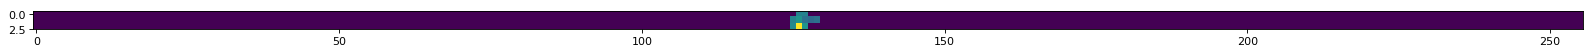

In [79]:
display_im(ww[0][0])

In [34]:
tt = numpy_to_tensor(np.array([3,4,5]))
tt.to(best_device())
tensor_info(tt)

(device(type='cpu'), torch.Size([3]), torch.int64)

In [10]:
word_batch(["chris","schrumm"]).shape

(2, 1, 3, 256)

In [8]:
# rtTreeName contains the name of the network to load 
# avWords (instance of WordManage) contains the list of available words.
# wdDic contains the chosen words root network choice
# maxDepth
def train_and_choose(rtTreeName,avWords,maxDepth,btch_count):
    '''
    1. Choose N words from avWords min(300,avWords.count)
    2. Create a new instance of get_network with rtTreeName
    3. For the chosen words do the following
        A. find out the category 1 through (category_count) of the words
        B. Now for train_batch count modify all the words using the initially selected
           word as the target.
    4. Now for all words in avWords assign them to on of the (categor_count) categories
    5. Save the network.
    6. If maxDepth <= 1 return..
    7. For 1 to (cagtegory_count) number of categories:
            maxDepth = maxDepth - 1
            A. Select all the elements of chosen category from the avWords.filter_cat(category)
               and append them to a new instance of avWords
            B. If there is more then one element in a category...
               B1. Recursively call train_and_choose with new avWords category and the sub network
                   name netname_ + category_number
            
    '''
    
    # step 1
    ws = avWords.choose(min(300,avWords.word_count()))
    wrk_d = { w : 0 for w in ws }
    
    # step 2
    ntwk = load_network(rtTreeName)
    
    # step 3 A.
    for w in ws:
        # get the category for the word.
        cat = get_category(ntwk,w)
        wrk_d[w] = cat
    
    for i in range(btch_count):
        for w in ws:
            # modify the word
            mw,cat = (messup_word(w),wrk_d[w])
            
    # step 6
    if maxDepth <= 1:
        return
    
    return

def spell_word(word,nd,wrList):
    '''
       NOT FINISHED...
       1. Load the network name.
       2. Find category for the word in the network.
       3. If wrList.has_more_one(category)
            with spell_word with word and netname_ + category_number
          elif wrList.has_one(category):
            
           
    '''
    pass

In [13]:
60*50*10

30000

In [228]:
wrl = WordManage()

In [229]:
wrl.set_words(sbst,0)

In [230]:
wrl.word_count()

1525

In [221]:
def remove_letter(wd):
    if len(wd) < 5:
        return wd
    cs = random.randint(0,len(wd)-1)
    return wd[0:cs] + wd[cs+1:]

def swap_letter(wd):
    if len(wd) < 3:
        return wd
    cs = random.randint(0,len(wd)-2)
    wd = [w for w in wd]
    t = wd[cs]
    wd[cs] = wd[cs+1]
    wd[cs+1] = t
    
    tmp = ""
    for w in wd:
        tmp += w
        
    return tmp

def change_letter(wd):    
    if len(wd) < 4:
        return wd
    
    alpha = ['a','b','c','d','e','f','g', \
        'h','i','j','k','l','m','n','o','p','q','r', \
        's','t','u','v','w','x','y','z']
    cs = random.randint(0,len(wd)-1)

    wd = [w for w in wd]
    
    wd[cs] = alpha[random.randint(0,25)]
    
    tmp = ""
    for w in wd:
        tmp += w
        
    return tmp

def drop_letter(wd):
    if len(wd) < 5:
        return wd
    cs = random.randint(0,len(wd)-2)
    
    wd = [w for w in wd]
    
    wd[cs] = ' '
    
    tmp = ""
    for w in wd:
        tmp += w
        
    return tmp   

def add_letter(wd):
    if len(wd) < 3:
        return wd
    
    #print("add letter")
    cs = random.randint(0,len(wd)-2)
    
    #wd = [w for w in wd]
    
    alpha = ['a','b','c','d','e','f','g', \
        'h','i','j','k','l','m','n','o','p','q','r', \
        's','t','u','v','w','x','y','z']
    
    #ln = len(wd)
    wd = wd[0:cs] + alpha[random.randint(0,25)] + wd[cs:] 
           
    return wd 


def word_mix(wd):
    fc_ar = [remove_letter,swap_letter,change_letter,drop_letter,add_letter]
    
    wd = fc_ar[random.randint(0,4)](wd)
    
    if random.random() < 0.4:
        wd = fc_ar[random.randint(0,4)](wd)
        
    if random.random() < 0.3:
        wd = fc_ar[random.randint(0,4)](wd)
        
    if random.random() < 0.2:
        wd = fc_ar[random.randint(0,4)](wd)
        
    return wd


In [205]:
nn = "chris"
print(nn[0:3] + nn[3:])

chris


In [220]:
s = "transportation"
print(len(s))

for i in range(100):    
    nw_s = word_mix(s)
    print(nw_s,"  ",len(nw_s))


14
transporta ion    14
transpportation    15
transport tion    14
transportatcion    15
 rans p tation    14
t asportation    13
transpportatiqn    15
tpransoprtation    15
tansp rtation    13
trnlasportation    15
tqansportatio    13
transportagion    14
transport  ion    14
t ansportation    14
yransportation    14
trazsportation    14
transportatdob    14
trmansportatijn    15
transporation    13
ctransportation    15
tr nsportation    14
 arnsportation    14
trntportation    13
trlansportation    15
transportatjion    15
transqportation    15
transpo rati n    14
transpritation    14
transporattion    14
vrrnsportation    14
transpotratiol    14
transporation    13
transmportatin    14
trangspiortation    16
t nsportation    13
transportjtion    14
transfortation    14
rtnsportation    13
trhanspoktation    15
trns rtatifon    13
trsnportation    13
transposrtation    15
tratlportaiton    14
tqanlsportation    15
ransportation    13
transportatiol    14
tranjpoxrtation    15
ransp

In [147]:
for i in range(30):
    print(random.randint(0,4))

2
1
0
3
4
4
4
1
4
0
1
4
3
0
2
2
1
3
4
2
2
2
3
3
0
2
1
0
0
2


In [141]:
def total_string_distance(t):
    tmp = []
    for a,b in itertools.permutations(t,2):
        tmp.append(jellyfish.damerau_levenshtein_distance(a,b) ** 2)        
    return sum(tmp)

def choose_spread_combo(nm,wrl):
    bts = []
    sms = []
    for i in range(75):
        t = wrl.choose_words(nm)
        bts.append(t)
        sms.append(total_string_distance(t))
    # print(sms,np.argmax(sms))
    return bts[np.argmax(sms)]
            
        

In [265]:
def build_choose_and_train(wrl):
    out_num = 5
    targ_arr = []
    in_arr = []
    wrds = choose_spread_combo(out_num, wrl)
    
    for en,v in enumerate(wrds):
        targ_arr.append(en)
        wrd = encode_word(v)
        wrd = np.expand_dims(wrd,axis=0)
        in_arr.append(wrd)
        
    for i in range(1000):
        for en,v in enumerate(wrds):
            targ_arr.append(en)
            wd = word_mix(v)
            wrd = encode_word(wd)
            wrd = np.expand_dims(wrd,axis=0)
            in_arr.append(wrd)
    tn_in, tn_trg  = np.stack(in_arr),np.array(targ_arr,dtype=np.long)
    
    epoch = 6
    example_size = len(targ_arr)
    example_indexes = [x for x in range(example_size)]
    
    model, optimizer, scheduler = build_net_opt_schedule()
    
    for i in range(epoch):
        for b in batch(example_indexes,64):
            #print(b[0],b[-1])
            
            optimizer.zero_grad()
            
            data = tn_in[b[0]:b[-1]]
            target = tn_trg[b[0]:b[-1]]
            
            data = numpy_to_tensor(data)
            target = numpy_to_tensor(target)
            
            output = model(data)
            
            loss = F.nll_loss(output,target)
            loss.backward()
            
            optimizer.step()
            
        scheduler.step()
        print("finished  epoch ", (i+1))
    '''
    model.train()
    
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        
    '''
    return model



In [264]:
mdl = build_choose_and_train(wrl)

finished  epoch  1
finished  epoch  2
finished  epoch  3
finished  epoch  4
finished  epoch  5
finished  epoch  6


In [274]:
cat_w = get_category(mdl,wrl.all_words())

['people', 'history', 'way', 'art', 'world', 'information', 'map', 'two', 'family', 'government', 'health', 'system', 'computer', 'meat', 'year', 'thanks', 'music', 'person', 'reading', 'method', 'data', 'food', 'understanding', 'theory', 'law', 'bird', 'literature', 'problem', 'software', 'control', 'knowledge', 'power', 'ability', 'economics', 'love', 'internet', 'television', 'science', 'library', 'nature', 'fact', 'product', 'idea', 'temperature', 'investment', 'area', 'society', 'activity', 'story', 'industry', 'media', 'thing', 'oven', 'community', 'definition', 'safety', 'quality', 'development', 'language', 'management', 'player', 'variety', 'video', 'week']
tensor([0, 0, 2, 2, 0, 1, 2, 2, 0, 1, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 2, 4, 3, 0,
        2, 4, 1, 0, 0, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 0, 0, 0, 2, 1, 1, 2, 0, 0,
        0, 0, 2, 2, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 4], device='cuda:0')
['security', 'country', 'exam', 'movie', 'organization', 'equipment', 'physics', 'analysis'

In [275]:
cat_w[0:50]

array([0, 0, 2, 2, 0, 1, 2, 2, 0, 1, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 2, 4,
       3, 0, 2, 4, 1, 0, 0, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 0, 0, 0, 2, 1,
       1, 2, 0, 0, 0, 0])

In [59]:
wrl.set_category('bike',2)
wrl.set_category('cause',2)
wrl.set_category('clerk',2)

In [61]:
l = wrl.filter_list(2)

In [65]:
l.choose_words(3)

['clerk', 'cause', 'bike']